# Build a complex model from scatch

This notebook shows the process of going from GIS data to an operational PRMS/pywatershed model of the Sagehen Creek Watershed, near Truckee, CA. In this notebook, we use functionality from `D-Any`, `FloPy`, and `pyGSFLOW` to construct an operational model of the basin.

The model that is created in this notebook discretized using a Voronoi grid and has local refinement around the streams. This approach reduces the total number of cells needed to accurately represent the flow system of the basin (when compared to a structured grid approach). 

This notebook does not cover in depth details of each of the functions that are used to construct the model. Instead it refers to other notebooks that cover the methods.

In [1]:
import os
import flopy
import dany
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import LineString

from pathlib import Path
from flopy.utils.voronoi import VoronoiGrid
from flopy.utils.triangle import Triangle
from flopy.plot import styles
from gsflow.builder import GenerateFishnet

from dataretrieval import nwis, nldi
from pyproj import Transformer

import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)
warnings.simplefilter("ignore", DeprecationWarning)
warnings.simplefilter("ignore", UserWarning)

Define paths for input data and model outputs 

In [2]:
data_ws = Path("../data")
output_ws = data_ws / "sagehen_voronoi_notebook"
dem_file = data_ws / "dem.img"
geospatial_ws = data_ws / "geospatial"

# soil rasters
awc = geospatial_ws / "awc.img"
ksat = geospatial_ws / "ksat.img"
clay = geospatial_ws / "clay.img"
sand = geospatial_ws / "sand.img"

# land cover rasters
nlcd2011 = geospatial_ws / "nlcd2011_imp_utm.img"
lf_cover = geospatial_ws / "us_140evc_utm.img"
lf_vegtype = geospatial_ws / "us_140evt_utm.img"

# climate rasters
ppt_rstrs = [geospatial_ws / f"climate/ppt_utm/PRISM_ppt_30yr_normal_800mM2_{i :02d}_bil.img" for i in range(1, 13)]
tmax_rstrs = [geospatial_ws / f"climate/tmax_utm/PRISM_tmax_30yr_normal_800mM2_{i :02d}_bil.img" for i in range(1, 13)]
tmin_rstrs = [geospatial_ws / f"climate/tmin_utm/PRISM_tmin_30yr_normal_800mM2_{i :02d}_bil.img" for i in range(1, 13)]

Load the Digital Elevation Model (DEM) raster

In [3]:
rstr = flopy.utils.Raster.load(dem_file)

Create a bounding box of decimal latitude and longitude for the raster.

In [4]:
epsg_utm = rstr.crs.to_epsg()
epsg_wgs84 = 4326  # decimal lat lon
crs_utm = f"EPSG:{epsg_utm}"
crs_wgs84 = f"EPSG:{epsg_wgs84}"

transformer = Transformer.from_crs(crs_utm, crs_wgs84, always_xy=True)

get decimal latitude longitude boundaries for the area of interest

In [5]:
xmin, xmax, ymin, ymax = rstr.bounds
xmin, ymin = transformer.transform(xmin, ymin)
xmax, ymax = transformer.transform(xmax, ymax)
wgs_bounds = [xmin, ymin, xmax, ymax]

Get gage information and basin boundary information for the basin using `dataretrieval`. This infomation will be used for building the model grid in subsequent steps

Get gage information for USGS streamgage [10343500](https://waterdata.usgs.gov/usa/nwis/inventory/?site_no=10343500&agency_cd=USGS)

In [6]:
info, meta = nwis.get_info(bBox=[f"{i :.2f}" for i in wgs_bounds])
info.to_crs(epsg=epsg_utm, inplace=True)
sitedf = info[info.site_no == "10343500"]
sitedf

agency_cd   site_no               station_nm site_tp_cd    lat_va  \
2      USGS  10343500  SAGEHEN C NR TRUCKEE CA         ST  392554.0   

     long_va  dec_lat_va  dec_long_va coord_meth_cd coord_acy_cd  ...  \
2  1201413.0   39.431572  -120.237979             M            F  ...   

  reliability_cd gw_file_cd  nat_aqfr_cd  aqfr_cd  aqfr_type_cd well_depth_va  \
2            NaN   NNNNNNNN          NaN      NaN           NaN           NaN   

  hole_depth_va depth_src_cd  project_no                        geometry  
2           NaN          NaN         NaN  POINT (221299.997 4369675.311)  

[1 rows x 43 columns]

Get the basin boundary

In [7]:
basindf = nldi.get_basin(
    feature_source="nwissite",
    feature_id=f"USGS-{sitedf.site_no.values[0]}"
)
basindf.to_crs(epsg=epsg_utm, inplace=True)
basindf

geometry
0  POLYGON ((220068.760 4366733.474, 219647.520 4...

#### Generate an initial Voronoi grid at fine scale using the basin information

These code blocks generate the initial Voronoi Grid. This representation will be used to get an initial stream location that we can use to generate our final model representation from.

Import `Triangle` and `VoronoiGrid` from `FloPy` to generate the initial grid. More information about how to use `Triangle` and `VoronoiGrid` can be found here: 
[Triangle and VoronoiGrid example FloPy](https://flopy.readthedocs.io/en/latest/Notebooks/dis_voronoi_example.html)


In [8]:
from flopy.utils.triangle import Triangle
from flopy.utils.voronoi import VoronoiGrid

Create a triangular mesh

In [9]:
ws = Path("./tri_initial")
ws.mkdir(exist_ok=True)

tri = Triangle(angle=30, model_ws=ws)
tri.add_polygon(basindf.geometry.values[0])
tri.add_region(basindf.centroid.values[0], 0, maximum_area=4000)
tri.build()

Build the voronoi mesh from the triangulation

In [10]:
vor = VoronoiGrid(tri)
vgrid = flopy.discretization.VertexGrid(nlay=1, **vor.get_gridprops_vertexgrid())

Plot the work that's been done so far

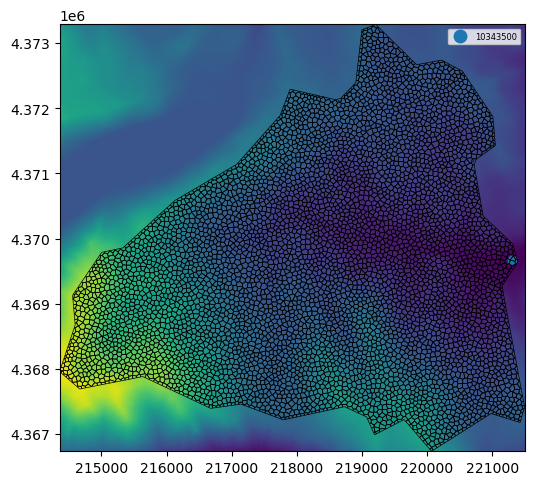

In [11]:
# plot the grid
fig, ax = plt.subplots(figsize=(6, 6))

rstr.plot(ax=ax)
pmv = flopy.plot.PlotMapView(modelgrid=vgrid, ax=ax)
pmv.plot_grid(color="k", lw=0.5)
sitedf.plot(column="site_no", ax=ax, cmap="tab20", legend=True, legend_kwds={"fontsize": 6});

#### Resample the raster to the voronoi mesh
`FloPy`'s raster class has a built in method that can be used for geostatical resampling of rasters to a grid discretization. To learn more about this please see [Flopy Raster example](https://flopy.readthedocs.io/en/latest/Notebooks/raster_intersection_example.html)

In [12]:
rstr = flopy.utils.Raster.load(dem_file)
resampled_dem = rstr.resample_to_grid(
    vgrid,
    band=rstr.bands[0],
    method="min"
)

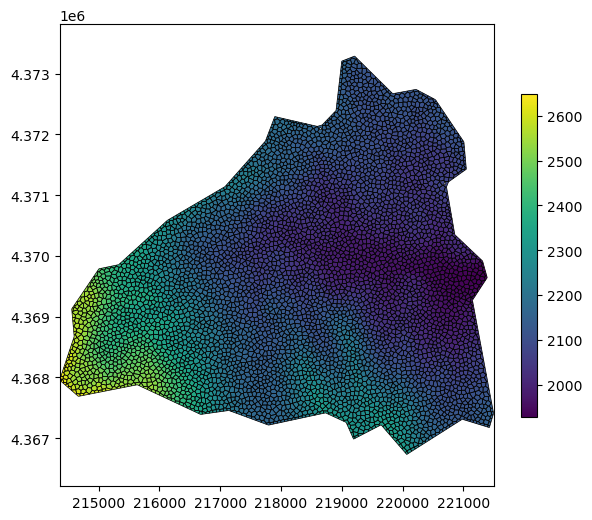

In [13]:
# plot the grid and the resampled dem
fig, ax = plt.subplots(figsize=(7, 6))
ax.axis("equal")
pmv = flopy.plot.PlotMapView(modelgrid=vgrid, ax=ax)
pc = pmv.plot_array(resampled_dem)
pmv.plot_grid(color="k", lw=0.5)
plt.colorbar(pc, shrink=0.7);

### Hydrologic conditioning

Hydrologic conditioning can be done with `dany.fill_sinks()`. This method uses a modified improved-epsilon priority flood sink filling method to condition the digital elevations. More information about this process can be found in the "Hydrologic_conditioning" notebook.

In [14]:
conditioned_dem = dany.fill_sinks(vgrid, resampled_dem)
conditioned_dem = dany.fill_nan_values(vgrid, conditioned_dem)

### Flow directions and flow accumulation

Flow directions and flow accumulation can be calculated using the `dany.FlowDirections` class. This class uses the "D-Any" algorithm to calculate flow directions. For more information on this process, see the "Flow directions and accumulation" notebook. 

In [15]:
fdobj = dany.FlowDirections(vgrid, conditioned_dem)
fdirs = fdobj.flow_directions()
facc = fdobj.flow_accumulation()

# get the flow direction vectors
qx, qy = fdobj.vectors

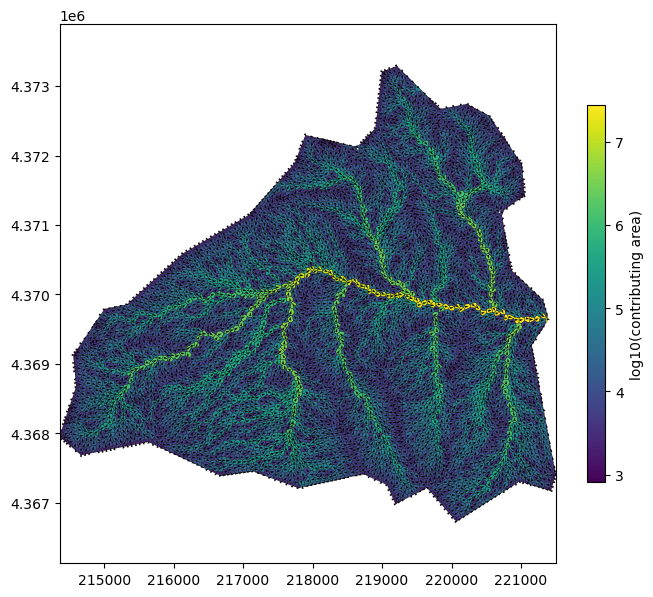

In [16]:
# plot the flow directions and flow accumulation array
fig, ax = plt.subplots(figsize=(8, 7))
ax.axis("equal")
pmv = flopy.plot.PlotMapView(modelgrid=vgrid, ax=ax)
pc = pmv.plot_array(np.log10(facc))
pmv.plot_vector(qx, qy)
pmv.plot_grid(color="k", lw=0.2)
plt.colorbar(pc, shrink=0.7, label="log10(contributing area)");

#### Generate an initial stream network

The `dany.PrmsStreams` class can be used to generate stream networks and produce PRMS input data including stream parameters and cascades. More information on this process can be found in the "Generating stream networks" notebook example

In [17]:
prms_strms = dany.PrmsStreams(vgrid, fdobj)
contrib_area = 1e6  # m^2
stream_array = prms_strms.delineate_streams(contrib_area)

Get the stream network as GIS shapes

In [18]:
vectors = prms_strms.create_stream_vectors(stream_array)
geom = [LineString(v) for v in vectors.values()]
segs = [k for k in vectors.keys()]
gdf = gpd.GeoDataFrame({"geometry": geom, "segments": segs})
gdf.set_crs(epsg=epsg_utm, inplace=True)
gdf.head()

geometry  segments
0  LINESTRING (220904.601 4368205.756, 220893.423...        15
1  LINESTRING (220806.906 4369251.855, 220817.821...        16
2  LINESTRING (221004.945 4369634.500, 221093.729...        17
3  LINESTRING (221393.078 4369642.523, 221393.078...        18
4  LINESTRING (218687.630 4368531.008, 218633.748...        10

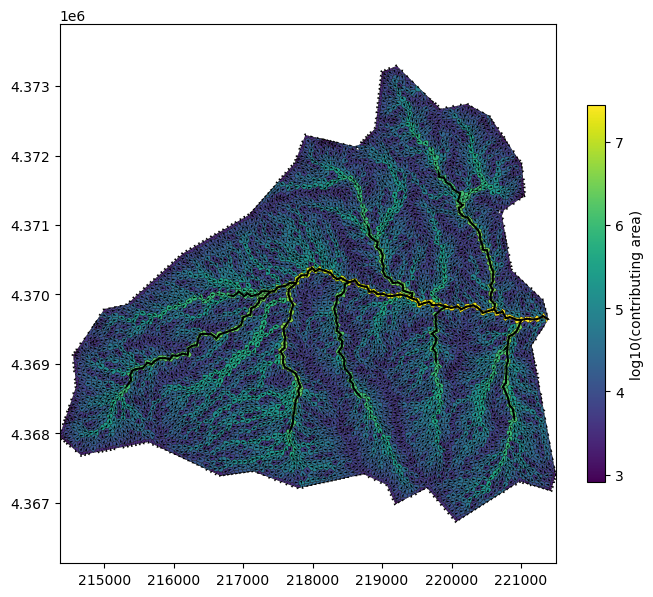

In [19]:
# plot the flow directions, flow accumulation array, and stream network
fig, ax = plt.subplots(figsize=(8, 7))
ax.axis("equal")
pmv = flopy.plot.PlotMapView(modelgrid=vgrid, ax=ax)
pc = pmv.plot_array(np.log10(facc))
pmv.plot_vector(qx, qy)
pmv.plot_grid(color="k", lw=0.2)
plt.colorbar(pc, shrink=0.7, label="log10(contributing area)")
gdf.plot(ax=ax, color="k");

## Now to add some complexity to the model

Instead of the Voronoi discretization that was just produced this example uses the stream lines we generated to create a more complex model discretization. 

The stream lines that were produced are going to be used to locally refine the grid around the stream locations to produce a voronoi mesh that has coarse grid cells in the watershed and fine grid cells around the streams. 

Start by dissolving and buffering the stream lines to create a single stream polygon for `Triangle`

In [20]:
gdf = gdf.dissolve()
gdf["geometry"] = gdf.geometry.buffer(50, cap_style=2, join_style=3)

And create the triangular and Voronoi mesh

In [21]:
tri_ws = Path("./tri_refined")
tri_ws.mkdir(exist_ok=True)

tri = flopy.utils.triangle.Triangle(angle=30, model_ws=tri_ws)
tri.add_polygon(basindf.geometry.values[0])
tri.add_polygon(gdf.geometry.values[0], ignore_holes=True)
tri.add_region(basindf.centroid.values[0], 0, maximum_area=10000)
tri.add_region(sitedf.geometry.values[0], 1, maximum_area=3000)
tri.build()

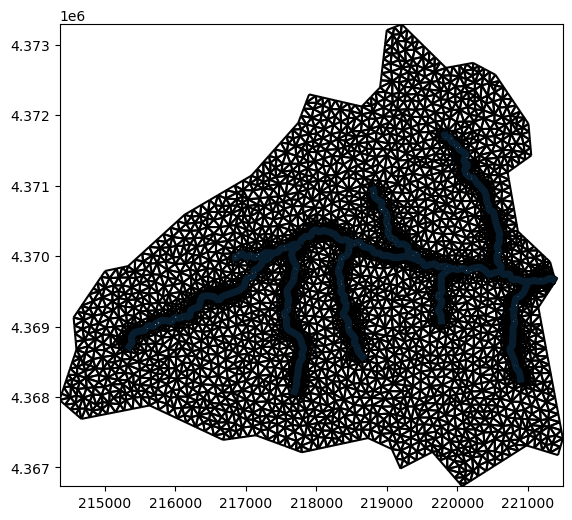

In [22]:
fig, ax = plt.subplots(figsize=(8, 6))
tri.plot(ax=ax)
gdf.geometry.plot(ax=ax, alpha=0.25, zorder=5);

In [23]:
vor = VoronoiGrid(tri)
gridprops = vor.get_gridprops_vertexgrid()
vgrid = flopy.discretization.VertexGrid(nlay=1, **gridprops)

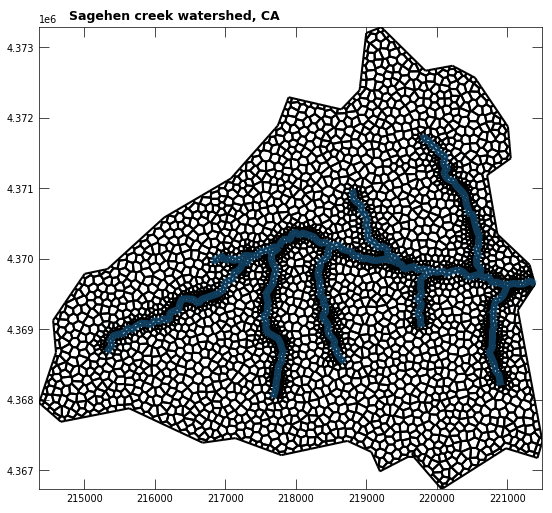

In [24]:
with styles.USGSMap():
    fig, ax = plt.subplots(figsize=(8, 6))
    pmv = flopy.plot.PlotMapView(modelgrid=vgrid, ax=ax)
    pmv.plot_grid(color="k")
    gdf.geometry.plot(ax=ax, alpha=0.50, zorder=5)
    styles.heading(ax=ax, x=0.06, heading="Sagehen creek watershed, CA");

#### Resample the raster to the new discretization


In [25]:
dem = rstr.resample_to_grid(
    vgrid,
    band=rstr.bands[0],
    method="min"
)
dem = np.where(dem == rstr.nodatavals[0], np.nan, dem)

#### Fill and hydrologically condition the DEM

The `D-Any` package includes methods to fill and hydrologically condition DEM data. See the "Hydrologic conditioning" notebook for more information on how it works.

In [26]:
filled_dem = dany.fill_nan_values(vgrid, dem, method="mean")
conditioned_dem = dany.fill_sinks(vgrid, filled_dem)

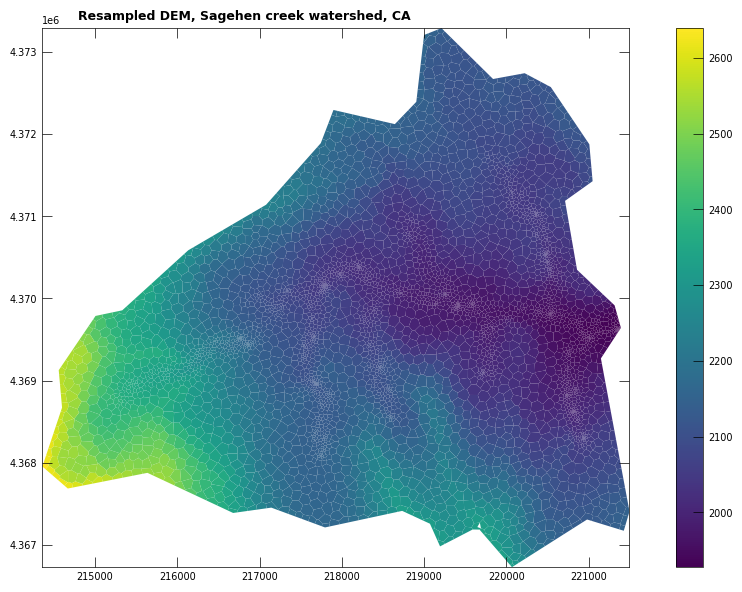

In [27]:
with styles.USGSPlot():
    fig, ax = plt.subplots(figsize=(12, 7))
    pmv = flopy.plot.PlotMapView(modelgrid=vgrid)
    pc = pmv.plot_array(conditioned_dem)
    pmv.plot_grid
    plt.colorbar(pc)
    styles.heading(ax=ax, x=0.06, heading="Resampled DEM, Sagehen creek watershed, CA")

# set the top elevation and a botm elevation on the grid
vgrid._top = conditioned_dem
vgrid._botm = np.array([conditioned_dem]) - 300

#### Calculate flow directions and flow accumulation

The `D-Any` package is used to calculation flow direction and flow accumulation. For more information see the "Flow directions and accumulation" notebook.

In [28]:
fdobj = dany.FlowDirections(vgrid, conditioned_dem)
fdir_arr = fdobj.flow_directions()
facc_arr = fdobj.flow_accumulation()

qx, qy = fdobj.vectors

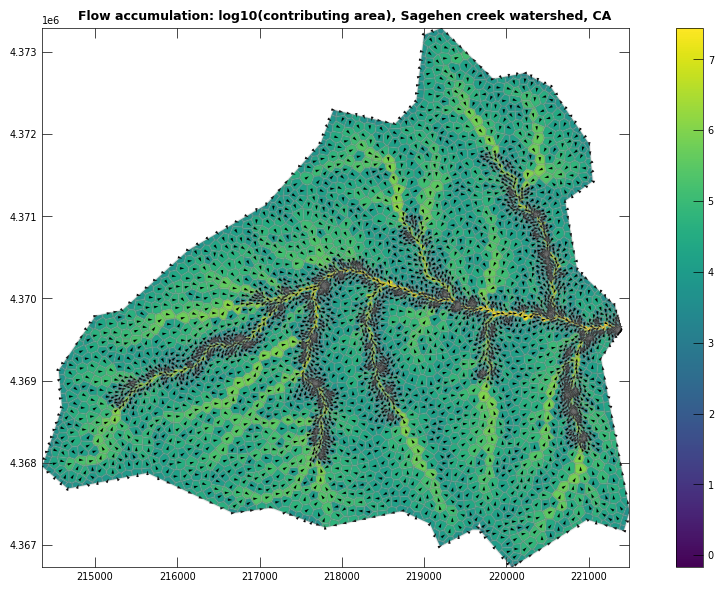

In [29]:
with styles.USGSMap():
    fig, ax = plt.subplots(figsize=(12, 7))
    pmv = flopy.plot.PlotMapView(modelgrid=vgrid) 
    pc = pmv.plot_array(np.log10(facc_arr))
    pmv.plot_vector(qx, qy)
    pmv.plot_grid(alpha=0.2)
    plt.colorbar(pc)
    styles.heading(ax=ax, x=0.06, heading="Flow accumulation: log10(contributing area), Sagehen creek watershed, CA")

#### Create the stream network
`dany.PrmsStreams` is used to create a stream network for PRMS and pywatershed. See the "Generating stream networks" notebook for more detail on how this works

In [30]:
contrib_area = 1.05e6
prms_strms = dany.PrmsStreams(vgrid, fdobj)
stream_array = prms_strms.delineate_streams(contrib_area)

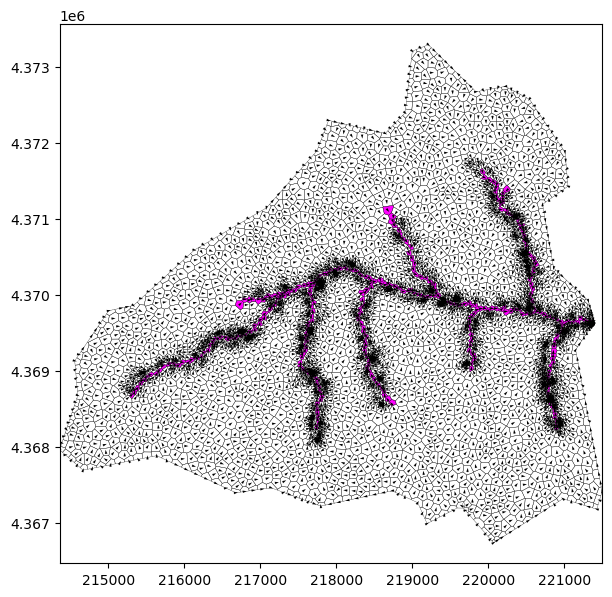

In [31]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.axis("equal")
pmv = flopy.plot.PlotMapView(modelgrid=vgrid, ax=ax)
pc = pmv.plot_array(stream_array, masked_values=[0], cmap="spring")
pmv.plot_vector(qx, qy)
pmv.plot_grid(color="k", lw=0.2);

#### Create a pyGSFLOW compatible cascade object

`D-Any` has built in compatibility support for `pygsflow` builder workflows like `gsflow.builder.PrmsBuilder()`. For more information about this method and the resulting object that's returned, see the "Generating stream networks" notebook.

In [32]:
print(vgrid.shape)
pgsf_cascades = prms_strms.get_pygsflow_builder_object(
    stream_array,
    group_segments=True,
)
# inspect the attributes of the cascades object
pgsf_cascades.__dict__

(1, 5178)


{'dany_flag': True,
 'ncascade': 9036,
 'hru_up_id': array([   1,    2,    3, ..., 4469, 5177, 5178]),
 'hru_down_id': array([4784, 4898, 4895, ..., 4471, 4471, 4116]),
 'hru_pct_up': array([1., 1., 1., ..., 1., 1., 1.]),
 'hru_strmseg_down_id': array([0, 0, 0, ..., 0, 0, 0]),
 'cascade_flag': 1,
 'hru_slope': array([0.32313919, 0.18318968, 0.15514565, ..., 0.25197792, 0.5418062 ,
        0.17163821]),
 'hru_aspect': array([ 32.39142605, 150.04026866,  27.36285019, ...,  55.86794818,
         32.54705681, 238.01193246]),
 'hru_area': array([ 1187.57177734,  6193.51281738,  3595.84350586, ...,
         4766.41912842, 10926.09796143, 14469.42352295]),
 'nsegments': 18,
 'nreaches': 416}

#### Create input files using pyGSFLOW's `PrmsBuilder()`.

At this point enough information about the surface water system has been generated to build an initial PRMS parameter file with pyGSFLOW's builder classes. Detailed information about the `PrmsBuilder()` class and the related `PrmsParameter` object it creates can be found here: [pyGSFLOW PrmsBuilder](https://github.com/pygsflow/pygsflow/blob/develop/examples/pygsflow1.1.0_Builder_tutorial_07_PrmsBuilder.ipynb)

In [33]:
from gsflow.builder import PrmsBuilder

In [34]:
prms_builder = PrmsBuilder(
    None,
    pgsf_cascades,
    vgrid,
    conditioned_dem.ravel()
)

In [35]:
parameters = prms_builder.build()
parameters

### Use pyGSFLOW and FloPy to add additional parameter information to the Parameter file

The rest of this exercise uses pyGSFLOW and FloPy to finish building an operational PRMS model. For more information on this, see the pyGSFLOW builder examples located here: [pyGSFLOW examples](https://github.com/pygsflow/pygsflow/tree/develop/examples)

In [36]:
import gsflow
import gsflow.builder.builder_utils as bu

Set hru latitude and longitude

In [37]:
gdf_grid = vgrid.geo_dataframe
gdf_grid.set_crs(epsg_utm, inplace=True)
gdf_grid.to_crs(epsg_wgs84, inplace=True)

parameters.set_values("hru_lat", gdf_grid.centroid.y.values)
parameters.set_values("hru_lon", gdf_grid.centroid.x.values)

array([-120.2510076 , -120.25633701, -120.26116902, ..., -120.31267362,
       -120.31195034, -120.24724862])

Resample land use, soil rasters, and climate rasters to create input parameters

In [38]:
raster = flopy.utils.Raster.load(lf_cover)
veg_cov = raster.resample_to_grid(
    vgrid,
    band=raster.bands[0],
    method="nearest",
)
veg_cov = veg_cov.astype(int)
# np.savetxt(veg_cov_file, veg_cov, fmt="%d")

In [39]:
raster = flopy.utils.Raster.load(lf_vegtype)
veg_type = raster.resample_to_grid(
    vgrid,
    band=raster.bands[0],
    method="nearest",
)
veg_type = veg_type.astype(int)
# np.savetxt(veg_type_file, veg_type, fmt="%d")

In [40]:
raster = flopy.utils.Raster.load(awc)
awc = raster.resample_to_grid(
    vgrid,
    band=raster.bands[0],
    method="median",
)
awc[awc == raster.nodatavals[0]] = np.nanmedian(awc)
# np.savetxt(awc_file, awc)

In [41]:
raster = flopy.utils.Raster.load(ksat)
ksat = raster.resample_to_grid(
    vgrid,
    band=raster.bands[0],
    method="median",
)
ksat[ksat == raster.nodatavals[0]] = np.nanmedian(ksat)
# np.savetxt(ksat_file, ksat)

In [42]:
raster = flopy.utils.Raster.load(sand)
sand = raster.resample_to_grid(
    vgrid,
    band=raster.bands[0],
    method="median",
)
sand[sand == raster.nodatavals[0]] = np.nanmedian(sand)
sand /= 100
# np.savetxt(sand_file, sand)

In [43]:
raster = flopy.utils.Raster.load(clay)
clay = raster.resample_to_grid(
    vgrid,
    band=raster.bands[0],
    method="median",
)
clay[clay == raster.nodatavals[0]] = np.nanmedian(clay)
clay /= 100
# np.savetxt(clay_file, clay)

In [44]:
raster = flopy.utils.Raster.load(nlcd2011)
impervious = raster.resample_to_grid(
    vgrid,
    band=raster.bands[0],
    method="median",
)
impervious /= 100
# np.savetxt(imperv_file, impervious)

In [45]:
ppt = []
for rstr in ppt_rstrs:
    raster = flopy.utils.Raster.load(rstr)
    tppt = raster.resample_to_grid(
        vgrid,
        band=raster.bands[0],
        method="linear",
    )
    ppt.append(tppt.ravel())
ppt = np.array(ppt)
# np.savetxt(ppt_file, ppt)

In [46]:
tmin = []
for rstr in tmin_rstrs:
    raster = flopy.utils.Raster.load(rstr)
    ttmin = raster.resample_to_grid(
        vgrid,
        band=raster.bands[0],
        method="linear",
    )
    tmin.append(ttmin.ravel())
tmin = np.array(tmin)
# np.savetxt(tmin_file, tmin)

In [47]:
tmax = []
for rstr in tmax_rstrs:
    raster = flopy.utils.Raster.load(rstr)
    ttmax = raster.resample_to_grid(
        vgrid,
        band=raster.bands[0],
        method="linear",
    )
    tmax.append(ttmax.ravel())
tmax = np.array(tmax)
# np.savetxt(tmax_file, tmax)